In [13]:
import os
import scanpy as sc
from genomemanager.gtf_utils import read_gtf
import pandas as pd
import anndata as ad
import numpy as np
# Imports for the notebook

In [14]:
def load_spaceranger_coding_genes(visium_output_dir, 
                                  resolution="002um", 
                                  gtf_path="/storage/research/dbmr_luisierlab/group/genomics/annotation/hg38/GENCODE/gencode.v44.chr_patch_hapl_scaff.annotation.gtf", 
                                  filtered=True):
    """
    Load Space Ranger binned outputs and filter for protein-coding genes.
    
    Parameters:
    -----------
    visium_output_dir : str
        Path to the Space Ranger output directory (e.g., .../outs)
    resolution : str
        Resolution bin size (e.g., "002um", "008um", "016um")
    gtf_path : str
        Path to the GTF annotation file
        
    Returns:
    --------
    adata_coding : AnnData
        AnnData object filtered for protein-coding genes
    """
    import os
    import scanpy as sc
    from genomemanager.gtf_utils import read_gtf
    
    # Construct path to binned outputs
    square_dir = os.path.join(visium_output_dir, "binned_outputs", f"square_{resolution}")
    positions = pd.read_parquet(os.path.join(square_dir, "spatial", "tissue_positions.parquet"))
    
    if not os.path.exists(square_dir):
        raise FileNotFoundError(f"Directory not found: {square_dir}")
    
    # Load the matrix with scanpy
    print(f"Loading {resolution} resolution matrix...")
    if filtered:
        adata = sc.read_10x_h5(os.path.join(square_dir, "filtered_feature_bc_matrix.h5"))
    else:
        adata = sc.read_10x_h5(os.path.join(square_dir, "raw_feature_bc_matrix.h5"))
    
    print(f"Loaded {resolution} matrix:")
    print(f"  Shape: {adata.shape} (spots × genes)")
    print(f"  Total UMIs: {adata.X.sum():,.0f}")
    
    # Load GTF annotation to get protein-coding genes
    print(f"\nLoading GTF annotation from: {gtf_path}")
    hg38 = read_gtf(gtf_path)
    hg38_coding = hg38[hg38["gene_type"] == "protein_coding"]
    hg38_coding_genes = list(hg38_coding['gene_name'].unique())
    print(f"Found {len(hg38_coding_genes)} protein-coding genes in GTF")
    
    # Fix duplicate gene names in adata
    print(f"\nChecking for duplicate gene names...")
    print(f"  Total genes: {len(adata.var_names)}")
    print(f"  Unique genes: {len(adata.var_names.unique())}")
    
    if len(adata.var_names) != len(adata.var_names.unique()):
        print("  Making gene names unique...")
        adata.var_names_make_unique()
        print("  Done!")
    
    # Filter to retain only protein-coding genes
    genes_to_keep = [g for g in adata.var_names if g in hg38_coding_genes]
    print(f"\nFound {len(genes_to_keep)} coding genes in adata (of {len(hg38_coding_genes)} total coding genes)")
    
    if len(genes_to_keep) == 0:
        raise RuntimeError("No coding genes were found in adata.var_names")
    
    # Subset to coding genes
    adata_coding = adata[:, genes_to_keep].copy()
    
    print(f"\nFinal filtered data:")
    print(f"  Shape: {adata_coding.shape}")
    print(f"  Total UMIs: {adata_coding.X.sum():,.0f}")

    adata_coding.obs = adata_coding.obs.merge(positions, left_index=True, right_on="barcode")
    print(f"Added spatial positions to adata_coding.obs")
    
    return adata_coding

In [21]:
def aggregate_spots_to_resolution(adata, current_resolution_um, target_resolution_um, verbose=True):
    """
    Aggregate spatial transcriptomics spots to a larger resolution.
    
    This function takes spots at a fine resolution and aggregates them into larger spots
    by summing expression counts. It uses grid-based binning with proper order preservation.
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with spatial coordinates in .obs
        Must contain: 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    current_resolution_um : float
        Current resolution in micrometers (e.g., 2 for 2um spots)
    target_resolution_um : float
        Target resolution in micrometers (e.g., 100 for 100um spots)
    verbose : bool
        Whether to print progress information
        
    Returns:
    --------
    adata_aggregated : AnnData
        New AnnData object with aggregated spots
        
    Example:
    --------
    >>> # Aggregate 2um spots to 100um spots
    >>> large_adata = aggregate_spots_to_resolution(adata_002um, 
    ...                                              current_resolution_um=2, 
    ...                                              target_resolution_um=100)
    """
    from scipy.sparse import csr_matrix
    import numpy as np
    import pandas as pd
    import anndata as ad
    
    # Calculate bin size (how many spots to aggregate)
    bin_size = int(target_resolution_um / current_resolution_um)
    
    if verbose:
        print(f"Aggregating from {current_resolution_um}um to {target_resolution_um}um resolution")
        print(f"Bin size: {bin_size}x{bin_size} spots")
    
    # Get array coordinates
    coords = adata.obs[['array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']].copy()
    
    # Create large spot grid by binning array coordinates
    coords['large_grid_row'] = (coords['array_row'] // bin_size).astype(int)
    coords['large_grid_col'] = (coords['array_col'] // bin_size).astype(int)
    
    # Create unique identifier for each large spot
    coords['large_spot_id'] = coords['large_grid_row'].astype(str) + '_' + coords['large_grid_col'].astype(str)

    spots_per_large = coords.groupby('large_spot_id').size()
    if verbose:
        print(f"\nOriginal number of small spots: {len(coords)}")
        print(f"Number of large spots: {coords['large_spot_id'].nunique()}")
        print(f"Average small spots per large spot: {len(coords) / coords['large_spot_id'].nunique():.2f}")
        
        # Show distribution of spots per large spot
        
        print(f"\nDistribution of small spots per large spot:")
        print(spots_per_large.value_counts().sort_index())

    ## Keep only the large spots that contains 95% of expected number of small spots
    expected_small_spots = bin_size**2

    print(f"Removing spots where we don't have the expected number of bins...")

    spots_per_large = spots_per_large[spots_per_large == expected_small_spots]
    # coords = coords[coords['large_spot_id'].isin(spots_per_large.index)]

    # adata.obs['large_grid_row'] = (adata.obs['array_row'] // bin_size).astype(int)
    # adata.obs['large_grid_col'] = (adata.obs['array_col'] // bin_size).astype(int)
    # adata.obs['large_spot_id'] = adata.obs['large_grid_row'].astype(str) + '_' + adata.obs['large_grid_col'].astype(str)
    # adata.obs.set_index('large_spot_id', inplace=True)
    expr_matrix = adata.X
    
    # Create mapping from original spots to large spots
    spot_to_large = coords['large_spot_id'].values
    
    # Create a mapping matrix: rows = large spots, columns = small spots
    unique_large_spots = coords['large_spot_id'].unique()
    large_spot_to_idx = {spot: idx for idx, spot in enumerate(unique_large_spots)}
    
    # Create index arrays for sparse matrix
    small_spot_indices = np.arange(len(coords))
    large_spot_indices = np.array([large_spot_to_idx[spot] for spot in spot_to_large])
    
    data = np.ones(len(coords))
    aggregation_matrix = csr_matrix((data, (large_spot_indices, small_spot_indices)), 
                                     shape=(len(unique_large_spots), len(coords)))
    
    # Aggregate expression: sum counts from all small spots in each large spot
    print(f"Shapes: aggregation matrix shape: {aggregation_matrix.shape}")
    print(f"Shapes: expression matrix shape: {expr_matrix.shape}")
    large_spot_expr = aggregation_matrix @ expr_matrix
    
    if verbose:
        print(f"\nOriginal expression matrix shape: {expr_matrix.shape}")
        print(f"Aggregated expression matrix shape: {large_spot_expr.shape}")
    
    # Create new AnnData object for large spots
    adata_aggregated = ad.AnnData(X=large_spot_expr, var=adata.var.copy())
    
    # Calculate center coordinates for large spots
    large_spot_coords = coords.groupby('large_spot_id').agg({
        'pxl_row_in_fullres': 'mean',
        'pxl_col_in_fullres': 'mean',
        'large_grid_row': 'first',
        'large_grid_col': 'first',
        'array_row': 'min',  # Keep track of original array coords
        'array_col': 'min'
    }).reset_index()
    
    # CRITICAL FIX: Reorder large_spot_coords to match the order of unique_large_spots used in aggregation
    large_spot_coords_ordered = large_spot_coords.set_index('large_spot_id').loc[unique_large_spots].reset_index()
    
    if verbose:
        print("\nOrder matches after reordering:", 
              (list(unique_large_spots) == large_spot_coords_ordered['large_spot_id'].tolist()))
    
    # Update adata_aggregated.obs with the correctly ordered coordinates
    adata_aggregated.obs = large_spot_coords_ordered.set_index('large_spot_id')
    adata_aggregated.obs['n_genes'] = (adata_aggregated.X > 0).sum(axis=1).A1
    adata_aggregated.obs['total_counts'] = adata_aggregated.X.sum(axis=1).A1
    
    adata_aggregated = adata_aggregated[adata_aggregated.obs.index.isin(spots_per_large.index),:]
    
    if verbose:
        print(f"\nAggregated AnnData created:")
        print(f"  Shape: {adata_aggregated.shape}")
        print(f"  Total UMIs: {adata_aggregated.X.sum():,.0f}")
        print(f"  Mean UMIs per spot: {adata_aggregated.obs['total_counts'].mean():.1f}")
        print(f"  Mean genes per spot: {adata_aggregated.obs['n_genes'].mean():.1f}")
    
    return adata_aggregated

In [16]:
visium_output_dir = "/storage/research/dbmr_luisierlab/temp/lfournier/Data/Ovarian_Visium_GTOP/hg38/spaceranger/A1_NAB_HUG_14/outs"
path_to_fullres_img = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/Visium_HD/HE_high_res_NAB-HUG-14/NAB-HUG-14_HE_Visium3_Scan1.qptiff"


In [17]:
adata_002um_coding = load_spaceranger_coding_genes(visium_output_dir, 
                                                   resolution="002um",
                                                   gtf_path="/storage/research/dbmr_luisierlab/group/genomics/annotation/hg38/GENCODE/gencode.v44.chr_patch_hapl_scaff.annotation.gtf", 
                                                   filtered=False)

Loading 002um resolution matrix...


/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loaded 002um matrix:
  Shape: (11222500, 38606) (spots × genes)
  Total UMIs: 6,031,313

Loading GTF annotation from: /storage/research/dbmr_luisierlab/group/genomics/annotation/hg38/GENCODE/gencode.v44.chr_patch_hapl_scaff.annotation.gtf
Found 20280 protein-coding genes in GTF

Checking for duplicate gene names...
  Total genes: 38606
  Unique genes: 38584
  Making gene names unique...
  Done!
Found 20280 protein-coding genes in GTF

Checking for duplicate gene names...
  Total genes: 38606
  Unique genes: 38584
  Making gene names unique...
  Done!

Found 19411 coding genes in adata (of 20280 total coding genes)

Final filtered data:
  Shape: (11222500, 19411)
  Total UMIs: 5,868,283

Found 19411 coding genes in adata (of 20280 total coding genes)

Final filtered data:
  Shape: (11222500, 19411)
  Total UMIs: 5,868,283
Added spatial positions to adata_coding.obs
Added spatial positions to adata_coding.obs


/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [18]:
adata_002um_coding

AnnData object with n_obs × n_vars = 11222500 × 19411
    obs: 'barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'

In [22]:
adata_100um = aggregate_spots_to_resolution(adata=adata_002um_coding, current_resolution_um=2, target_resolution_um=100)

Aggregating from 2um to 100um resolution
Bin size: 50x50 spots

Original number of small spots: 11222500

Original number of small spots: 11222500
Number of large spots: 4489
Number of large spots: 4489
Average small spots per large spot: 2500.00

Distribution of small spots per large spot:
2500    4489
dtype: int64
Removing spots where we don't have the expected number of bins...
Average small spots per large spot: 2500.00

Distribution of small spots per large spot:
2500    4489
dtype: int64
Removing spots where we don't have the expected number of bins...
Shapes: aggregation matrix shape: (4489, 11222500)
Shapes: expression matrix shape: (11222500, 19411)

Original expression matrix shape: (11222500, 19411)
Aggregated expression matrix shape: (4489, 19411)
Shapes: aggregation matrix shape: (4489, 11222500)
Shapes: expression matrix shape: (11222500, 19411)

Original expression matrix shape: (11222500, 19411)
Aggregated expression matrix shape: (4489, 19411)

Order matches after reor

In [24]:
adata_100um.obs

,pxl_row_in_fullres,pxl_col_in_fullres,large_grid_row,large_grid_col,array_row,array_col,n_genes,total_counts
large_spot_id,,,,,,,,
0_0,21539.677598,22655.781774,0,0,0,0,3,3.0
0_1,21138.598714,22654.544291,0,1,0,50,2,2.0
0_2,20737.519974,22653.306808,0,2,0,100,8,9.0
0_3,20336.441378,22652.069325,0,3,0,150,9,9.0
0_4,19935.362927,22650.831843,0,4,0,200,5,5.0
...,...,...,...,...,...,...,...,...
66_62,-3244.643108,-3889.966573,66,62,3300,3100,10,11.0
66_63,-3645.668794,-3891.199135,66,63,3300,3150,24,27.0
66_64,-4046.694336,-3892.431695,66,64,3300,3200,22,25.0


In [25]:
import openslide

# Open the whole slide image
slide = openslide.OpenSlide(path_to_fullres_img)

# Get basic properties
print(f"Image dimensions (level 0): {slide.dimensions}")
print(f"Number of levels: {slide.level_count}")
print(f"Level dimensions: {slide.level_dimensions}")
print(f"Level downsamples: {slide.level_downsamples}")

# Get a thumbnail for quick visualization
thumbnail = slide.get_thumbnail(slide.dimensions)


Image dimensions (level 0): (19200, 23040)
Number of levels: 4
Level dimensions: ((19200, 23040), (9600, 11520), (4800, 5760), (2400, 2880))
Level downsamples: (1.0, 2.0, 4.0, 8.0)


In [26]:
# Get the slide resolution
print("All properties:")
for key in sorted(slide.properties.keys()):
    if 'resolution' in key.lower() or 'mpp' in key.lower():
        print(f"{key}: {slide.properties[key]}")

# Get resolution from TIFF properties
y_resolution = float(slide.properties.get('tiff.YResolution', 0))
x_resolution = float(slide.properties.get('tiff.XResolution', 0))

print(f"\nX Resolution: {x_resolution} pixels/cm")
print(f"Y Resolution: {y_resolution} pixels/cm")

# Convert to microns per pixel
# Resolution is in pixels/cm, so we need: cm/pixel * 10000 microns/cm
microns_per_pixel_x = 10000 / x_resolution if x_resolution > 0 else None
microns_per_pixel_y = 10000 / y_resolution if y_resolution > 0 else None

print(f"\nMicrons per pixel (X): {microns_per_pixel_x:.4f} µm/pixel")
print(f"Microns per pixel (Y): {microns_per_pixel_y:.4f} µm/pixel")

All properties:
tiff.ResolutionUnit: centimeter
tiff.XResolution: 40126.380797114987
tiff.YResolution: 40126.380797114987

X Resolution: 40126.38079711499 pixels/cm
Y Resolution: 40126.38079711499 pixels/cm

Microns per pixel (X): 0.2492 µm/pixel
Microns per pixel (Y): 0.2492 µm/pixel


/tmp/ipykernel_3834801/1283022013.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


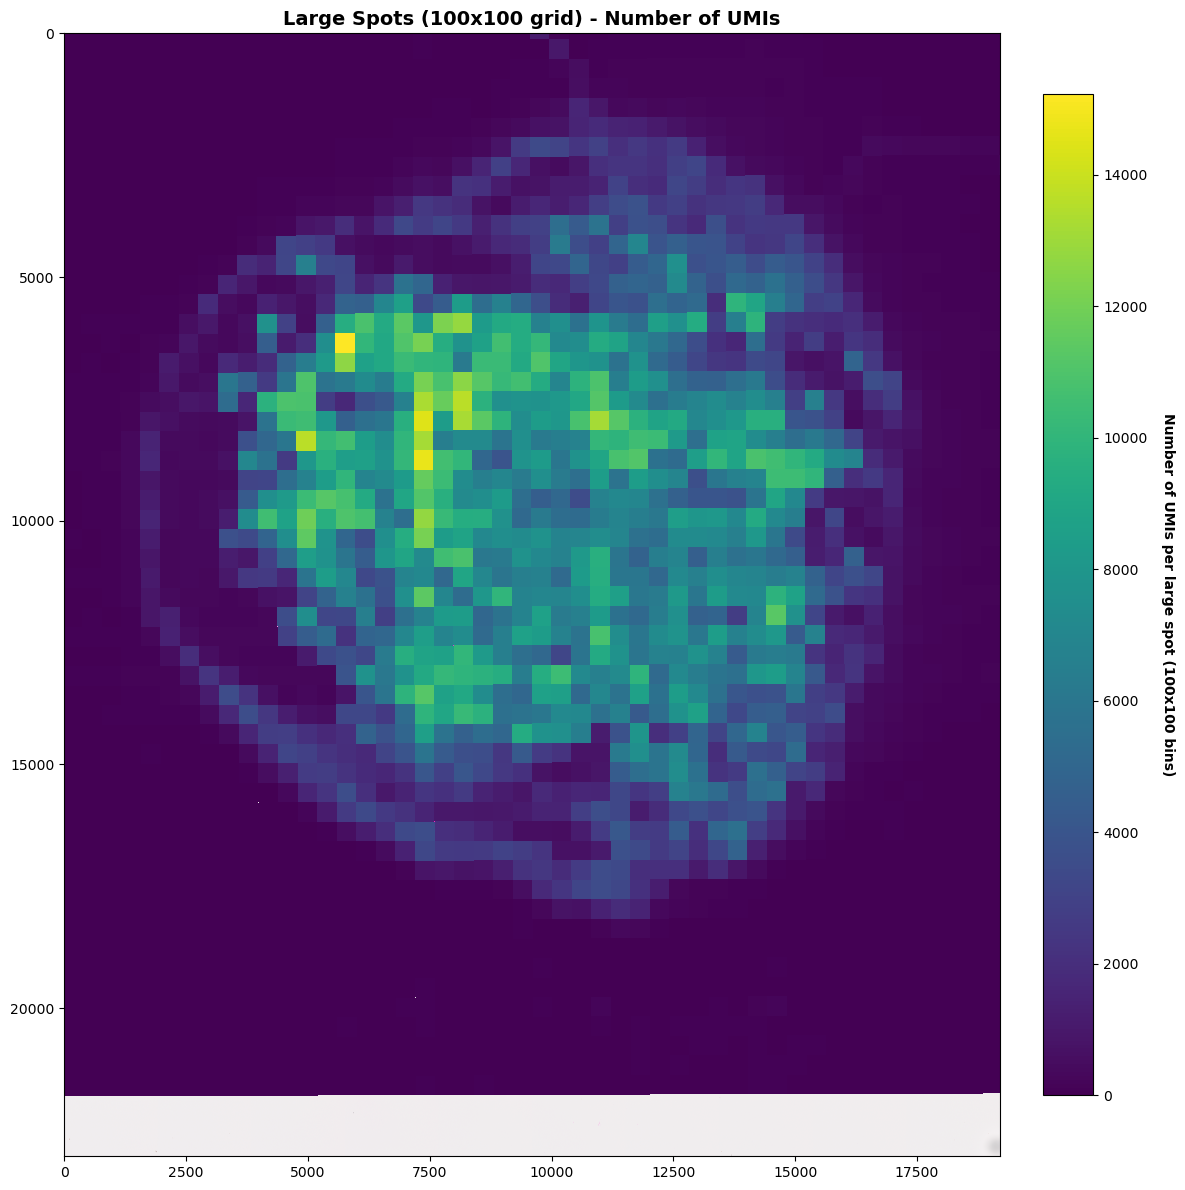


Total large spots plotted: 4489


In [27]:
# Visualize the large spots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

spot_dim = 100 / microns_per_pixel_x


# Get n_genes per large spot
n_genes_large = adata_100um.obs['total_counts'].values

# Create colormap normalization
vmin = n_genes_large.min()
vmax = n_genes_large.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('viridis')

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))
black_image = np.zeros((thumbnail.size[1], thumbnail.size[0], 3), dtype=np.uint8)
ax.imshow(thumbnail)

# Plot large spots with color representing n_genes
for i, (idx, row) in enumerate(adata_100um.obs.iterrows()):
    x = row['pxl_col_in_fullres']
    y = row['pxl_row_in_fullres']
    color = cmap(norm(n_genes_large[i]))
    rect = plt.Rectangle((x - spot_dim/2, y - spot_dim/2), 
                         spot_dim, spot_dim,  facecolor=color, alpha=1)
    ax.add_patch(rect)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Number of UMIs per large spot (100x100 bins)', rotation=270, labelpad=20, fontweight='bold')

plt.title("Large Spots (100x100 grid) - Number of UMIs", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nTotal large spots plotted: {len(adata_100um)}")

Then, filter with the shannon entropy pipeline. 